In [33]:
%matplotlib inline

In [2]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from time import time
import operator 
import json
from collections import defaultdict

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import json

ModuleNotFoundError: No module named 'tweepy'

In [35]:
csvfile = 'gender-classifier-DFE-791531.csv'
data = pd.read_csv(csvfile, encoding='latin-1')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [36]:
data.describe()

,_unit_id,_trusted_judgments,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,tweet_id
count,2.005000e+04,20050.000000,20024.000000,20050.000000,20050.000000,20050.000000,2.005000e+04,2.005000e+04
mean,8.157294e+08,3.615711,0.882756,0.993221,4382.201646,0.079401,3.892469e+04,6.587350e+17
std,6.000801e+03,12.331890,0.191403,0.047168,12518.575919,2.649751,1.168371e+05,5.000124e+12
min,8.157192e+08,3.000000,0.000000,0.627200,0.000000,0.000000,1.000000e+00,6.587300e+17
25%,8.157243e+08,3.000000,0.677800,1.000000,11.000000,0.000000,2.398000e+03,6.587300e+17
50%,8.157294e+08,3.000000,1.000000,1.000000,456.000000,0.000000,1.144150e+04,6.587300e+17
75%,8.157345e+08,3.000000,1.000000,1.000000,3315.500000,0.000000,4.002750e+04,6.587400e+17
max,8.157580e+08,274.000000,1.000000,1.000000,341621.000000,330.000000,2.680199e+06,6.587400e+17


In [37]:
data['gender'].value_counts()

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

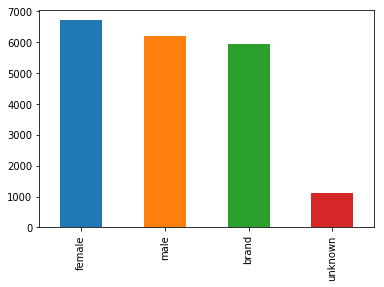

In [38]:
pd.value_counts(data['gender']).plot.bar()

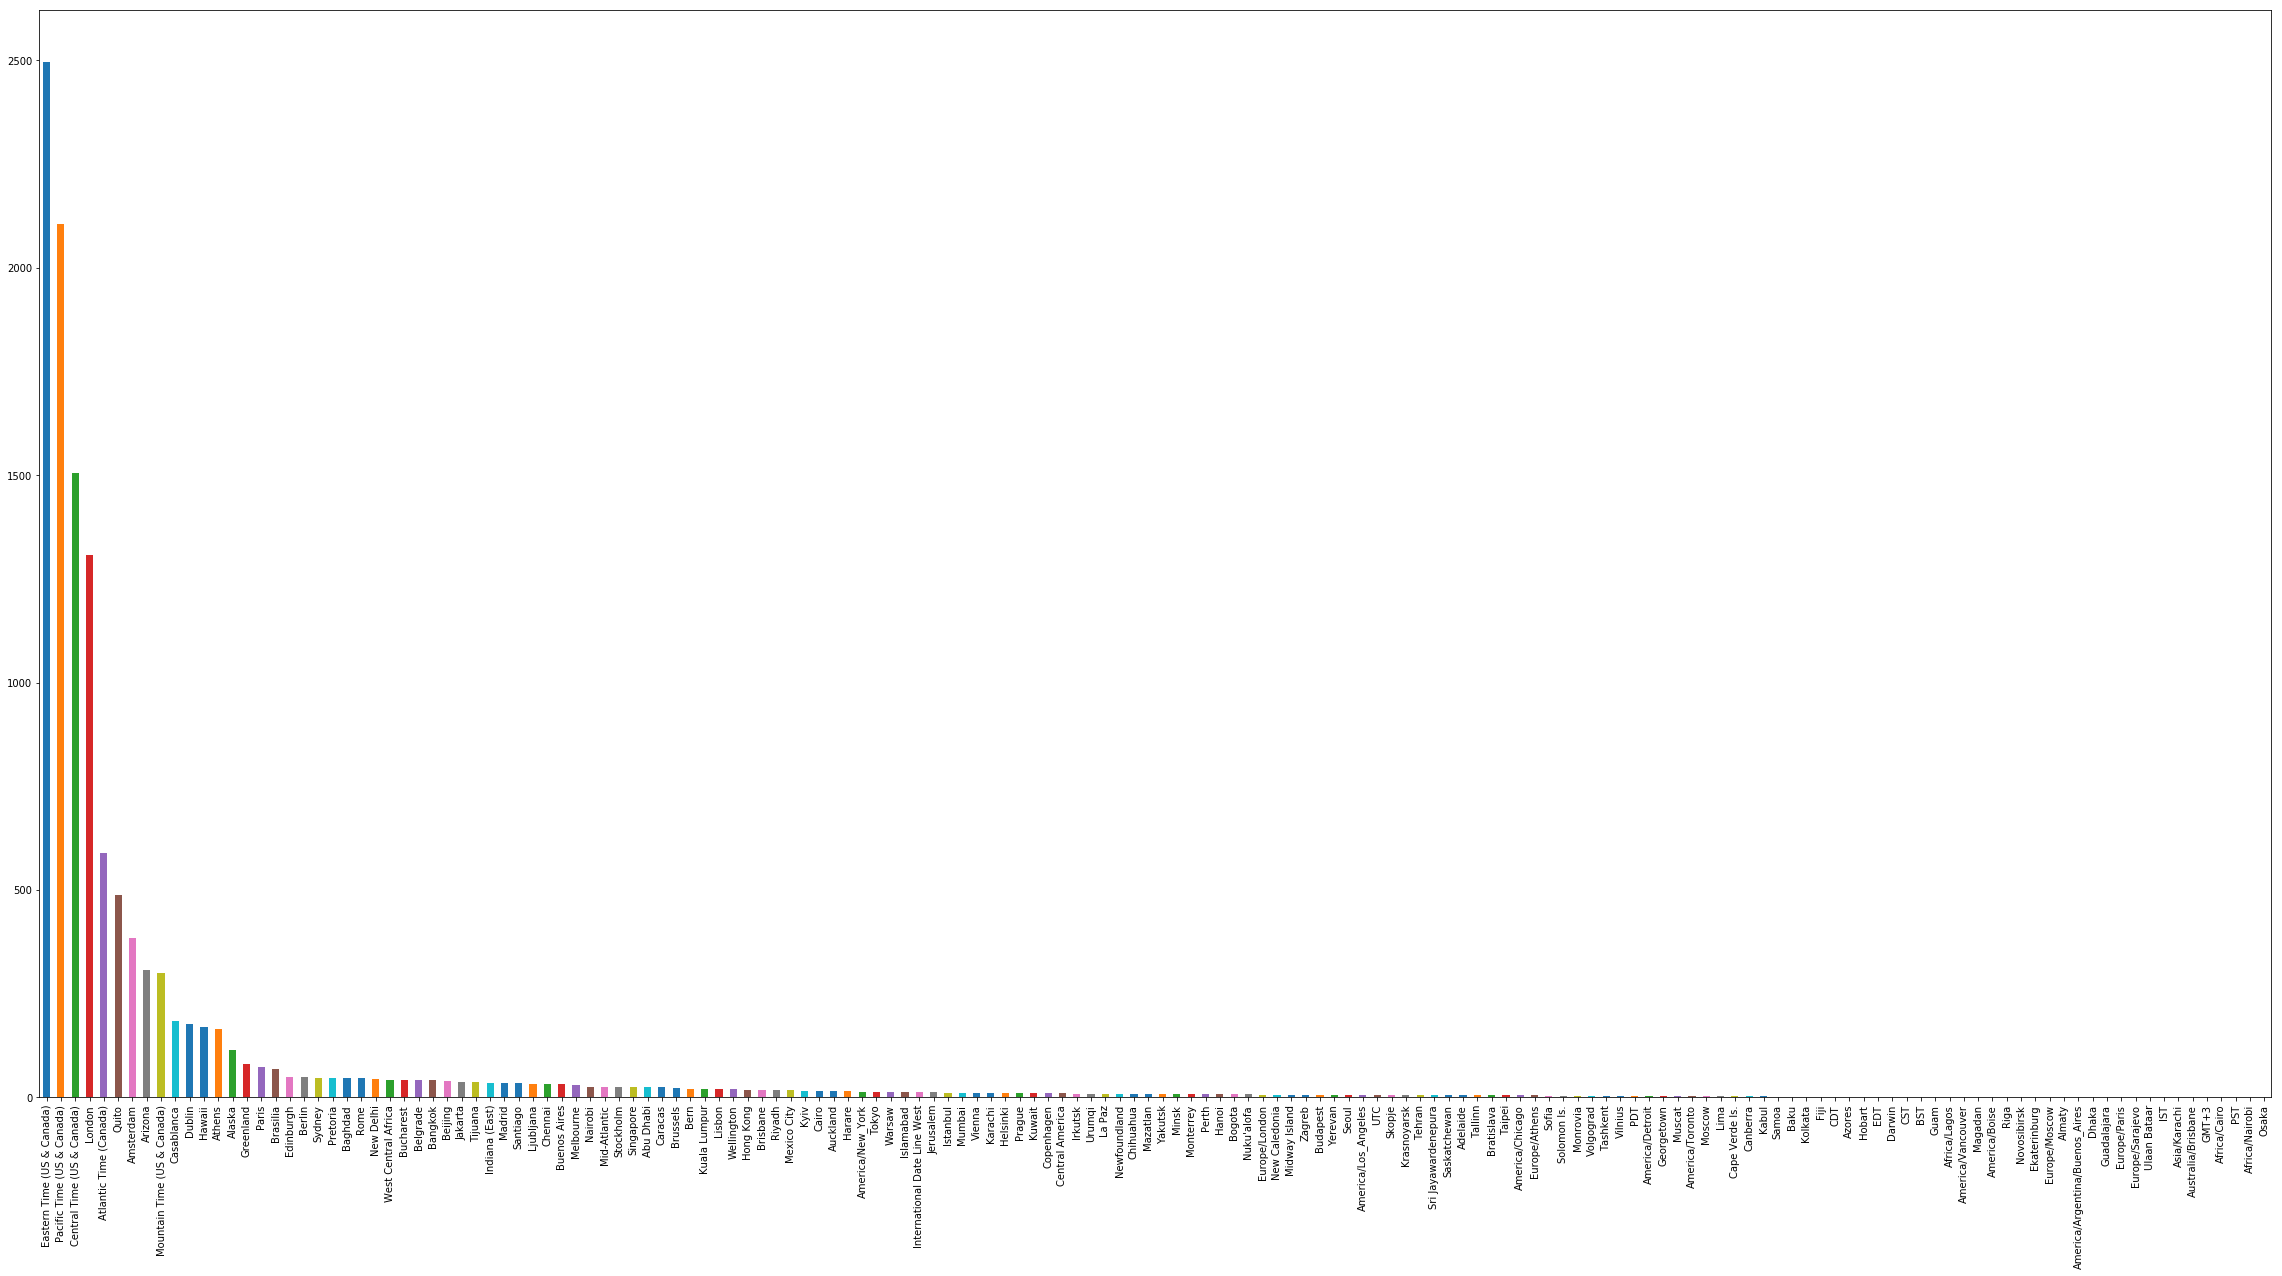

In [39]:
plt.figure(figsize=(40,20))
pd.value_counts(data['user_timezone']).plot.bar()

In [40]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
 
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation
ps = PorterStemmer()

import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    try:
        s=s.encode(encoding='ascii',errors='ignore')
    except:
        s=s
    return re.findall(pattern=tokens_re,string=s.decode('ascii'))
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [ps.stem(token) for token in tokens]
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

# stop_words = set(stopwords.words('english'))
df = data[['text','gender']]
df.dropna(inplace=True)
df = df[df.gender != 'unknown']
# # lower case
# df['text'] = df['text'].str.lower()
# for index, row in df.iterrows():
#     # tokenization
#     tokens = word_tokenize(row['text'])
#     terms = []
#     for token in tokens:
#         # stop words and punctuation removal
#         if token not in stop_words and token not in string.punctuation:
#             # stemming
#             token = ps.stem(token)
#             terms.append(token)
#     row['text'] = " ".join(terms)

C:\Users\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
terms_male = Counter()
terms_female = Counter()
terms_brand = Counter()

dic = {'male' : terms_male, 'female' : terms_female, 'brand' : terms_brand}
for index, row in df.iterrows():
    terms_all = [term for term in preprocess(row['text'],True) if term not in stop]
    dic[row['gender']].update(terms_all)

In [42]:
print(terms_female.most_common(100))

[('thi', 552), ("i'm", 528), ('like', 482), ('get', 457), ('wa', 442), ('go', 412), ('__', 399), ('love', 392), ('day', 360), ('one', 358), ('make', 335), ("it'", 314), ('time', 290), ('want', 256), ('peopl', 245), ('know', 232), ('new', 218), ('follow', 217), ('look', 217), ('amp', 203), ('___', 195), ('best', 192), ('got', 190), ('thank', 189), ('see', 189), ('need', 182), ('last', 182), ('thing', 181), ('think', 176), ('hi', 175), ('back', 175), ('say', 173), ('work', 173), ('good', 169), ('come', 169), ('onli', 165), ('2', 163), ('feel', 163), ('still', 160), ("can't", 159), ('watch', 149), ('fuck', 149), ('even', 148), ('year', 147), ('take', 144), ('u', 143), ('ha', 141), ("i'v", 140), ("you'r", 139), ('life', 139), ('today', 139), ('girl', 138), ('vote', 138), ('tri', 137), ('whi', 137), ('right', 134), ('realli', 132), ('happi', 129), ('im', 129), ('would', 128), ('lol', 126), ('becaus', 121), ('friend', 120), ('much', 120), ('alway', 119), ('way', 117), ('never', 116), ('ever'

In [12]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
y_train, y_test = train.gender, test.gender

<BarContainer object of 50 artists>

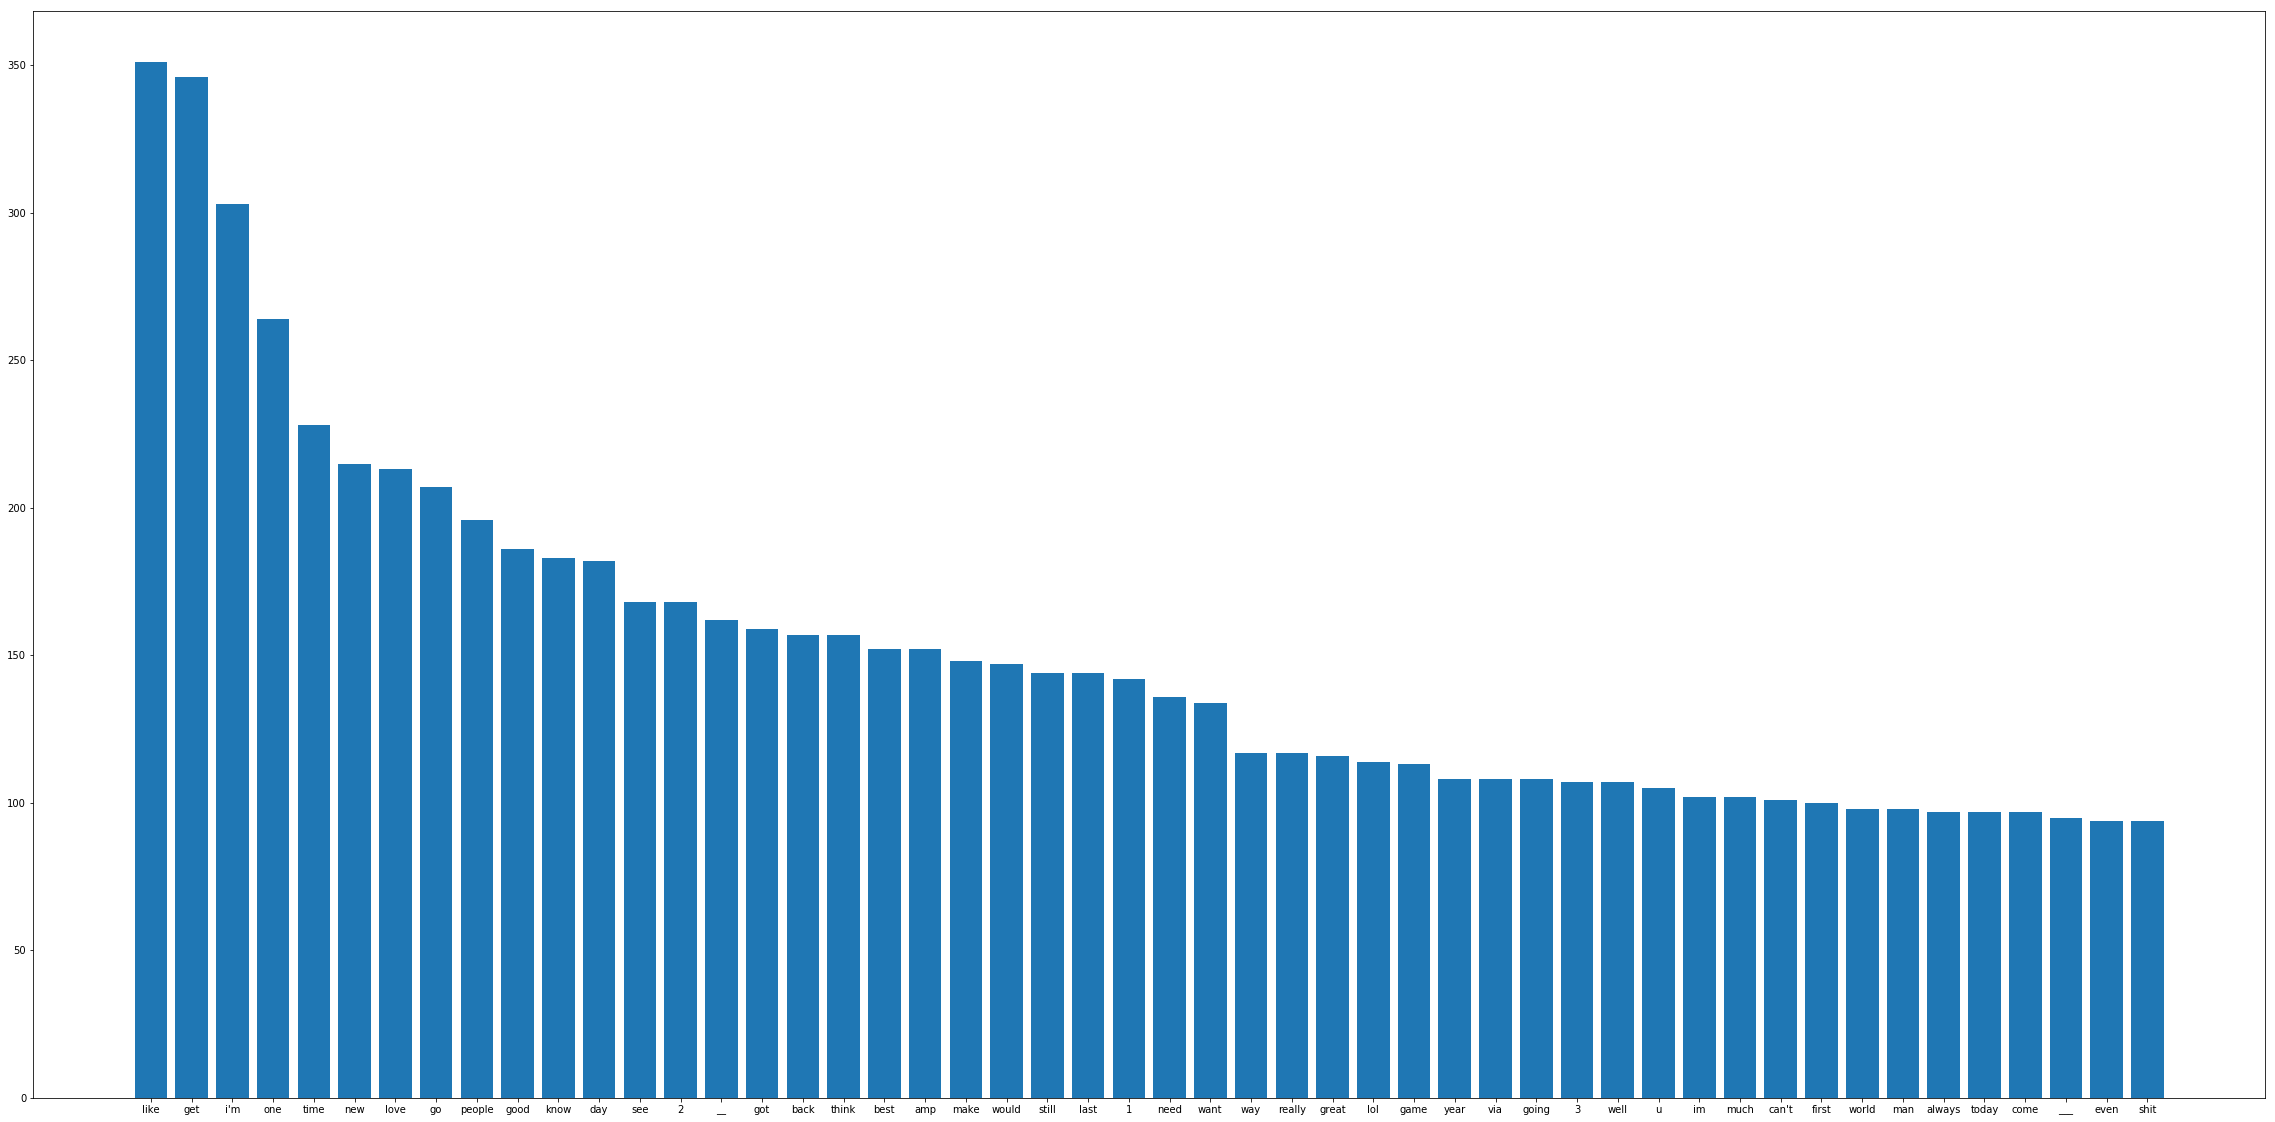

In [13]:
keys = []
values = []
for x, y in terms_male.most_common(50):
    keys.append(x)
    values.append(y)
plt.figure(figsize=(40,20))
plt.bar(keys, values)

<BarContainer object of 50 artists>

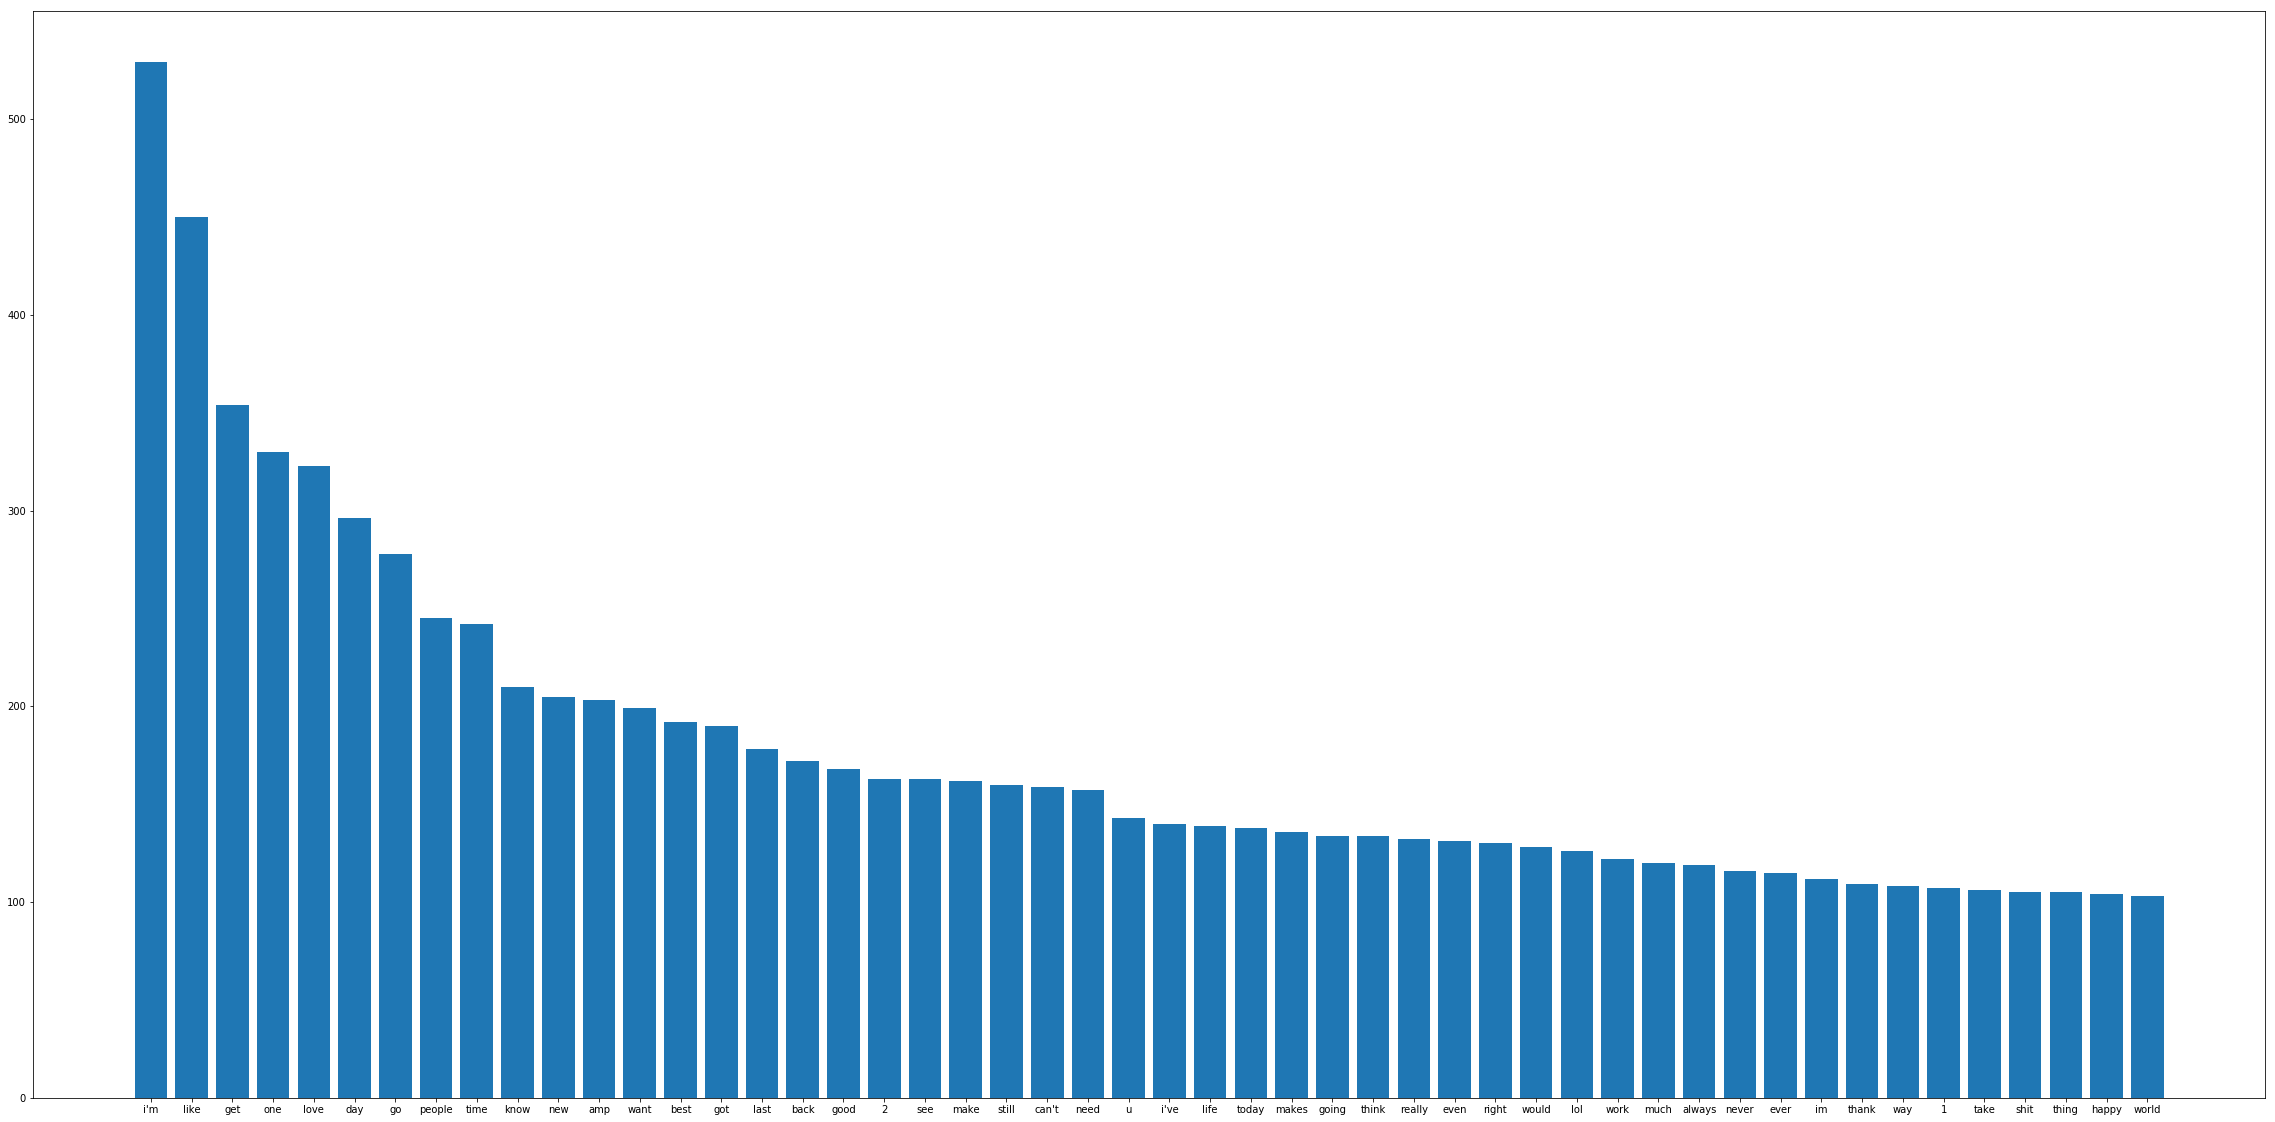

In [13]:
keys = []
values = []
for x, y in terms_female.most_common(50):
    keys.append(x)
    values.append(y)
plt.figure(figsize=(40,20))
plt.bar(keys, values)

In [ ]:
for index, row in train.iterrows():
    train['text'] = str(train['text'])
    
print("Extracting features from the training data using a sparse vectorizer")
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0,
                                 stop_words='english')
X_train = vectorizer.fit_transform(train.text)

print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
X_test = vectorizer.transform(test.text)
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

C:\Users\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


SVM
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.103s
test time:  0.000s
accuracy:   0.353

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.062s
test time:  0.000s
accuracy:   0.334

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior

C:\Users\Alon\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Alon\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


train time: 0.039s
test time:  0.000s
accuracy:   0.353



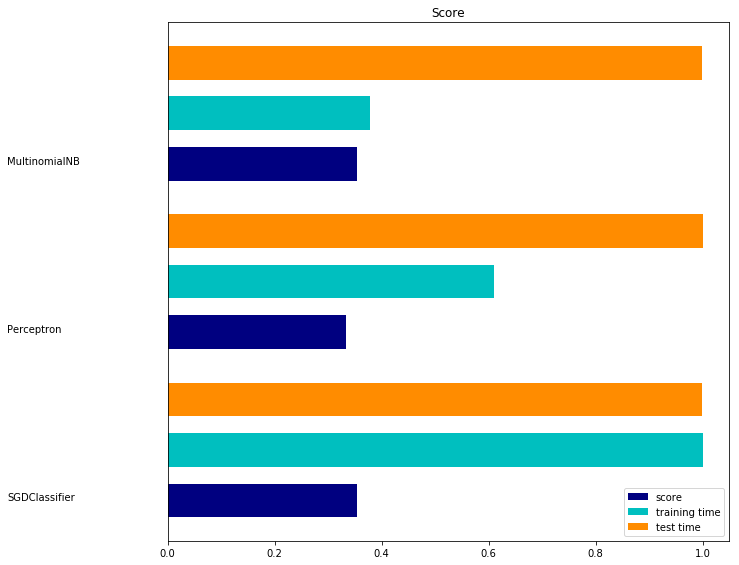

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (SGDClassifier(),"SVM"),
        (Perceptron(), "Perceptron"),
        (MultinomialNB(),"Naive Bayes")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
#Variables that contains the user credentials to access Twitter API 
consumer_key='GFVoG2WrusR9TxXOkO1sWXqBz'
consumer_secret='cOWwZRiyV1jwadldkoVVNoOHmpaYViw9CqPcnmQTvjvEFkam21'
access_token='1082610684578488320-eeFIYjm3EFA7JGlbnabDhgY8DTRy2y'
access_token_secret='J0SY0OaFwVDkMqDTykI1Qerrcf86ASAD52CX8aG2BC8Nu'
json_data=[]
names=[]
screen_names=[]
texts=[]
hashtags=[]
LIMIT_OF_TWEETS=15000

#This is a basic listener that just prints received tweets to stdout.
class StdOutListener(StreamListener):

    def on_data(self, data):
        if(len(json_data)<LIMIT_OF_TWEETS):
            tweet = json.loads(data)
            json_data.append(tweet)
            names.append(tweet['user']['name'])
            screen_names.append(tweet['user']['screen_name'])
            texts.append(tweet['text'])
            hashtags.append(tweet['entities']['hashtags'])
            return True
        else:
            stream.disconnect() #after collext 15000 tweets disconnect

    def on_error(self, status):
        print (status)


if __name__ == '__main__':
    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)
    #This line filter Twitter Streams to capture data by the most popular location in training data'
    #the most popular is US & Canada
    stream.filter(locations=[-162.8,28.2,-64.4,71.6])
    df = pd.DataFrame({'name': names, 'screen_name': screen_names,'text': texts,'hashtags':hashtags })
    #df.set_index('index')
    display(df)
    #important to the continue
    #row=df.loc[ 1 , : ]
    #display(row)
    #print(row['name'])
    print('done')    